# Facial Expression Recogniton

In [1]:
# Imports
import os
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

Lets Specify a preoject name to be able to commit file on jovian

In [2]:
project_name = '002facialexpressorecoglogisticapproach'

## Understanding the file structure

In [3]:
data_dir = '../input/facial-expression-recog-image-ver-of-fercdataset/Dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'labels.txt', 'test']
['anger', 'fear', 'surprise', 'happiness', 'sadness', 'neutral', 'disgust']


Lets see the number of images belonging to each classes in the training set

In [4]:
anger_files = os.listdir(data_dir + '/train/anger')
print('Total no. of images for training anager class: ',len(anger_files))

Total no. of images for training anager class:  4462


No. of training images of each class:-

In [5]:
for i in classes:
    var_files = os.listdir(data_dir + '/train/' + i)
    print(i,': ',len(var_files))

anger :  4462
fear :  4593
surprise :  3586
happiness :  8110
sadness :  5483
neutral :  5572
disgust :  493


## Creating the `dataset` variable

Lets convert all the images into tensor with the help of `ToTensor()`

In [6]:
dataset = ImageFolder(data_dir + '/train', transform = ToTensor())

In [7]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 32298
    Root location: ../input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train
    StandardTransform
Transform: ToTensor()


Lets have a look to the tensors and the labels

In [8]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 48, 48]) 0


tensor([[[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.

Our image is of 48*48 pixels and has 3 channels RGB, but though our image is B/W i don't know why its showing channel as 3, instead it should have shown 1.

Owooooooooo.....The dataset I created is working just perfectly.

In [9]:
print(dataset.classes)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


Lets have a look at some images.

In [10]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  anger (0)


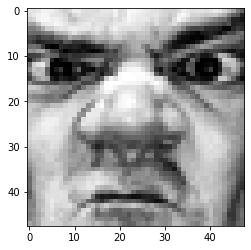

In [11]:
show_example(*dataset[172])

Yeah, Thats how an angry young man look like.

Now it's time to create our training and validation dataset

In [12]:
len(dataset)

32298

so our training dataset contains `32298` of toal images

In [13]:
val_size = int(0.1*32298)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size])
test_ds = ImageFolder(data_dir + '/test', transform = ToTensor())

In [14]:
print(train_ds)
print(val_ds)
print(test_ds)

Dataset ImageFolder
    Number of datapoints: 3589
    Root location: ../input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test
    StandardTransform
Transform: ToTensor()


## Data Loaders

In [15]:
# Hyperparmeters
batch_size = 64

# Other constants
input_size = 3*48*48
num_classes = 7

In [16]:
train_loader = DataLoader(
    train_ds, 
    batch_size, 
    shuffle=True         )

val_loader = DataLoader(
    val_ds, 
    batch_size*2       )

test_loader = DataLoader(
    test_ds, 
    batch_size*2        )

Label:  anger (0)


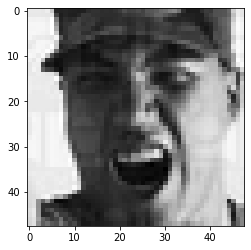

In [17]:
show_example(*train_ds[1])

Now, lets have a look at batch of images

images.shape: torch.Size([64, 3, 48, 48])


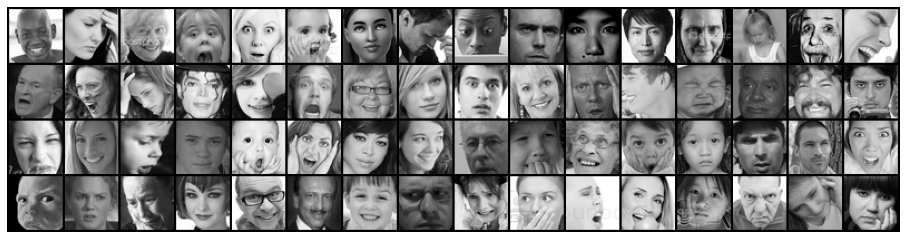

In [18]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model
It's time to define our model

In [19]:
class FacialExprRecog(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)#else xb.reshape(-1, 3*48*48)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = FacialExprRecog()

## Training

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
evaluate(model, val_loader)

{'val_loss': 1.9620035886764526, 'val_acc': 0.13636645674705505}

Lets start the training process

In [23]:
history = fit(50, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 5.3726, val_acc: 0.1693
Epoch [1], val_loss: 3.1519, val_acc: 0.3250
Epoch [2], val_loss: 3.8066, val_acc: 0.2252
Epoch [3], val_loss: 2.7604, val_acc: 0.2776
Epoch [4], val_loss: 6.0516, val_acc: 0.1426
Epoch [5], val_loss: 3.1076, val_acc: 0.1933
Epoch [6], val_loss: 5.0593, val_acc: 0.1698
Epoch [7], val_loss: 2.8411, val_acc: 0.3125
Epoch [8], val_loss: 3.0671, val_acc: 0.2704
Epoch [9], val_loss: 3.1728, val_acc: 0.1467
Epoch [10], val_loss: 6.2786, val_acc: 0.1681
Epoch [11], val_loss: 2.3318, val_acc: 0.3064
Epoch [12], val_loss: 1.9166, val_acc: 0.3242
Epoch [13], val_loss: 2.9858, val_acc: 0.2424
Epoch [14], val_loss: 3.5169, val_acc: 0.2834
Epoch [15], val_loss: 3.4322, val_acc: 0.2839
Epoch [16], val_loss: 2.7520, val_acc: 0.1794
Epoch [17], val_loss: 2.5621, val_acc: 0.3057
Epoch [18], val_loss: 4.4072, val_acc: 0.2098
Epoch [19], val_loss: 2.7592, val_acc: 0.2523
Epoch [20], val_loss: 4.0051, val_acc: 0.2240
Epoch [21], val_loss: 3.5230, val_acc: 0.159

In [24]:
history += fit(50, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6836, val_acc: 0.3704
Epoch [1], val_loss: 1.6872, val_acc: 0.3707
Epoch [2], val_loss: 1.6925, val_acc: 0.3637
Epoch [3], val_loss: 1.7109, val_acc: 0.3267
Epoch [4], val_loss: 1.6846, val_acc: 0.3586
Epoch [5], val_loss: 1.6698, val_acc: 0.3649
Epoch [6], val_loss: 1.6824, val_acc: 0.3574
Epoch [7], val_loss: 1.6863, val_acc: 0.3529
Epoch [8], val_loss: 1.7079, val_acc: 0.3482
Epoch [9], val_loss: 1.7139, val_acc: 0.3358
Epoch [10], val_loss: 1.6788, val_acc: 0.3520
Epoch [11], val_loss: 1.6742, val_acc: 0.3565
Epoch [12], val_loss: 1.7028, val_acc: 0.3452
Epoch [13], val_loss: 1.6726, val_acc: 0.3592
Epoch [14], val_loss: 1.6648, val_acc: 0.3601
Epoch [15], val_loss: 1.6699, val_acc: 0.3562
Epoch [16], val_loss: 1.6740, val_acc: 0.3463
Epoch [17], val_loss: 1.6685, val_acc: 0.3646
Epoch [18], val_loss: 1.6987, val_acc: 0.3493
Epoch [19], val_loss: 1.6654, val_acc: 0.3523
Epoch [20], val_loss: 1.6747, val_acc: 0.3577
Epoch [21], val_loss: 1.6653, val_acc: 0.358

In [25]:
history += fit(50, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6512, val_acc: 0.3643
Epoch [1], val_loss: 1.6512, val_acc: 0.3674
Epoch [2], val_loss: 1.6511, val_acc: 0.3625
Epoch [3], val_loss: 1.6515, val_acc: 0.3625
Epoch [4], val_loss: 1.6524, val_acc: 0.3631
Epoch [5], val_loss: 1.6512, val_acc: 0.3652
Epoch [6], val_loss: 1.6520, val_acc: 0.3622
Epoch [7], val_loss: 1.6517, val_acc: 0.3640
Epoch [8], val_loss: 1.6512, val_acc: 0.3604
Epoch [9], val_loss: 1.6514, val_acc: 0.3659
Epoch [10], val_loss: 1.6509, val_acc: 0.3637
Epoch [11], val_loss: 1.6512, val_acc: 0.3628
Epoch [12], val_loss: 1.6519, val_acc: 0.3628
Epoch [13], val_loss: 1.6518, val_acc: 0.3631
Epoch [14], val_loss: 1.6515, val_acc: 0.3640
Epoch [15], val_loss: 1.6524, val_acc: 0.3643
Epoch [16], val_loss: 1.6509, val_acc: 0.3649
Epoch [17], val_loss: 1.6519, val_acc: 0.3610
Epoch [18], val_loss: 1.6510, val_acc: 0.3637
Epoch [19], val_loss: 1.6515, val_acc: 0.3628
Epoch [20], val_loss: 1.6516, val_acc: 0.3643
Epoch [21], val_loss: 1.6538, val_acc: 0.360

## PLotting Functions are necessary too..

In [26]:
# Lets define a function for plotting graphs
def plot_accuracies(history):
    accuracies = [r['val_acc'] for r in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x', color='red')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs No. of Epoch')

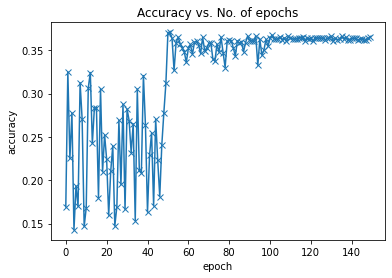

In [27]:
plot_accuracies(history)

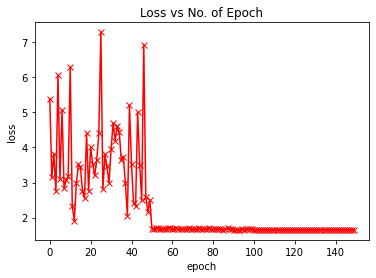

In [28]:
plot_losses(history)

In [29]:
evaluate(model, test_loader)

{'val_loss': 1.632269024848938, 'val_acc': 0.3803340792655945}

In [46]:
val_loss = 1.632
val_acc = 0.380
num_epochs = [50, 50, 50]
lr = [0.01, 0.001, 0.0001]

## Predictions
Now comes the final part

In [31]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: happiness , Predicted: happiness


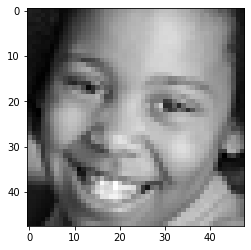

In [32]:
img, label = test_ds[1322]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Let's just see random 10 predictions

Label: happiness , Predicted: happiness


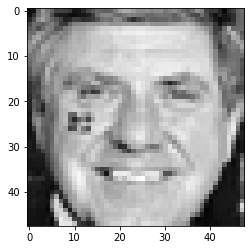

In [33]:
img, label = test_ds[1392]
plt.imshow(img[0], cmap='gray')
print('Label:', test_ds.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

# ---------The End----------

Comitting our work to Jovian with all the hyper params.

In [34]:
!pip install jovian --upgrade -q

In [47]:
import jovian
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/manishshah120/002facialexpressorecoglogisticapproach


<IPython.core.display.Javascript object>

Let's log all our hyperparams

In [48]:
jovian.log_dataset(dataset_url='https://www.kaggle.com/manishshah120/facial-expression-recog-image-ver-of-fercdataset', val_size=val_size)

[jovian] Dataset logged.


In [55]:
val_loss = 1.632
val_acc = 0.380

In [59]:
jovian.log_metrics(val_loss=1.632, val_acc=0.380)

[jovian] Metrics logged.


In [60]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'lr': lr,
})


[jovian] Hyperparams logged.


In [61]:
jovian.commit(project=project_name, message = 'Final', is_cli =True,environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/manishshah120/002facialexpressorecoglogisticapproach


<IPython.core.display.Javascript object>

In [ ]:
# will have to train this model with different epoch and lr batch_size, the move to feedfNN, cNN, resnet, trasnfer learning , at the last will have to deploy this model.